In [ ]:
# More imports
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, \
  BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

from PIL import Image

In [ ]:
# Load in the data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# map inputs to (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape:", x_train.shape)

x_train.shape: (60000, 28, 28)


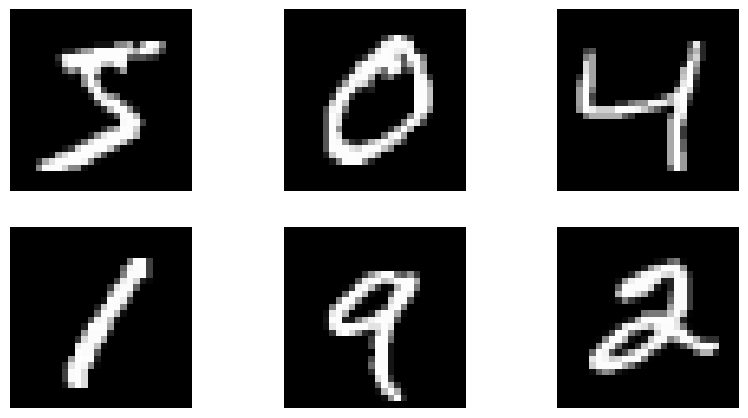

In [ ]:
# Display the dataset randomly
n_random = np.random.randint(0,len(x_train), 6)
plt.figure(figsize=(10,8))
for i in range(len(n_random)):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')

plt.show()

In [ ]:
# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [ ]:
print("x_train.shape:", x_train.shape)
print("x_test.shape:", x_test.shape)

x_train.shape: (60000, 784)
x_test.shape: (10000, 784)


## Generator & Discriminator Models

In [ ]:
# Dimensionality of the latent space
noise_dim = 100

In [ ]:
# Get the generator model
def build_generator(noise_dim):
    i = Input(shape=(noise_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)

    model = Model(i, x)
    return model

In [ ]:
# Get the discriminator model
def build_discriminator(img_size):
    i = Input(shape=(img_size,))                        # img_size --> vektor
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    return model

## Compile

In [ ]:
## Compile the "discriminator"
discriminator = build_discriminator(x_train.shape[1]) # real & fake_img(generator.predict(noise)) -> discriminator ->
                                                      # compile -> discriminator.train_on_batch() -> LOSS
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

In [ ]:
## Compile the "generator or combined model"
generator = build_generator(noise_dim)

In [ ]:
# Pass noise through generator to get an image
z = Input(shape=(noise_dim,))
gen_img = generator(z)       # NOISE or z(Input(shape=...)) -> generator -> gen_img -> DISCRIMINATOR -> prediction
                             # (z(Input(shape=...)) + prediction) akan di combined used Model() -> compile() ->
                             # combined_model.train_on_batch -> LOSS


#---------------------------------------------------------------------------------------------
## Make sure only the generator is trained, freeze the weights of "discriminator"
discriminator.trainable = False
fake_pred = discriminator(gen_img)               # The true output is fake, but we label them real!

combined_model = Model(z, fake_pred)             # Create the combined model object
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))     # Compile the combined model

In [ ]:
# A function to generate a grid of random samples from the generator
# and save them to a file

# Create a folder to store generated images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')


def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, noise_dim)
    imgs = generator.predict(noise)

    # Rescale images 0 - 1
    imgs = 0.5 * imgs + 0.5


    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

## Train

In [ ]:
## Train the GAN
# Config
batch_size = 32
epochs = 2000
sample_period = 200 # every `sample_period` steps generate and save some data


# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

In [ ]:
# Main training loop
for epoch in range(epochs):
    #######################################################################################
    ###                            Train discriminator                                  ###
    #######################################################################################

    # Select a random batch of "realimages"
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]                                            # (32, 784)

    # Generate "fake images"
    noise = np.random.randn(batch_size, noise_dim)                      # (32, 100)
    fake_imgs = generator.predict(noise)                                # (32, 784)

    # Train the discriminator (used real + fake images)
    # both loss and accuracy are returned
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc  = 0.5 * (d_acc_real + d_acc_fake)


    #######################################################################################
    ###                                Train generator                                  ###
    #######################################################################################
    # Train the generator (used noise (noise_dims = 100 vektor random number)
    noise = np.random.randn(batch_size, noise_dim)
    g_loss = combined_model.train_on_batch(noise, ones)

    # do it again!
    noise = np.random.randn(batch_size, noise_dim)
    g_loss = combined_model.train_on_batch(noise, ones)

    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
            d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

    if epoch % sample_period == 0:
        sample_images(epoch)


epoch: 1/2000, d_loss: 0.38,             d_acc: 0.73, g_loss: 0.72
epoch: 101/2000, d_loss: 0.05,             d_acc: 1.00, g_loss: 4.04
epoch: 201/2000, d_loss: 0.57,             d_acc: 0.72, g_loss: 1.29
epoch: 301/2000, d_loss: 0.70,             d_acc: 0.47, g_loss: 0.61
epoch: 401/2000, d_loss: 0.70,             d_acc: 0.44, g_loss: 0.63
epoch: 501/2000, d_loss: 0.69,             d_acc: 0.48, g_loss: 0.64
epoch: 601/2000, d_loss: 0.69,             d_acc: 0.47, g_loss: 0.68
epoch: 701/2000, d_loss: 0.65,             d_acc: 0.53, g_loss: 0.68
epoch: 801/2000, d_loss: 0.67,             d_acc: 0.52, g_loss: 0.69
epoch: 901/2000, d_loss: 0.65,             d_acc: 0.61, g_loss: 0.75
epoch: 1001/2000, d_loss: 0.66,             d_acc: 0.61, g_loss: 0.75
epoch: 1101/2000, d_loss: 0.64,             d_acc: 0.62, g_loss: 0.74
epoch: 1201/2000, d_loss: 0.62,             d_acc: 0.77, g_loss: 0.79
epoch: 1301/2000, d_loss: 0.69,             d_acc: 0.53, g_loss: 0.75
epoch: 1401/2000, d_loss: 0.71, 

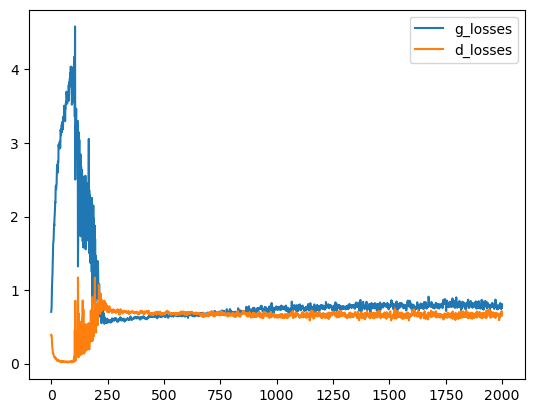

In [ ]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

## Plotting sample fake images

In [ ]:
ls gan_images

 Volume in drive C is Windows
 Volume Serial Number is 1E82-E31B

 Directory of C:\Users\Fernanda Januar\gan_images

21/10/2024  15:47    <DIR>          .
21/10/2024  15:49    <DIR>          ..
21/10/2024  15:43           185.959 0.png
21/10/2024  15:45           155.684 1000.png
21/10/2024  15:46           152.165 1200.png
21/10/2024  15:46           147.372 1400.png
21/10/2024  15:47           140.023 1600.png
21/10/2024  15:47           138.925 1800.png
21/10/2024  15:44           206.875 200.png
21/10/2024  15:44           166.524 400.png
21/10/2024  15:44           157.069 600.png
21/10/2024  15:45           156.886 800.png
              10 File(s)      1.607.482 bytes
               2 Dir(s)  197.464.424.448 bytes free


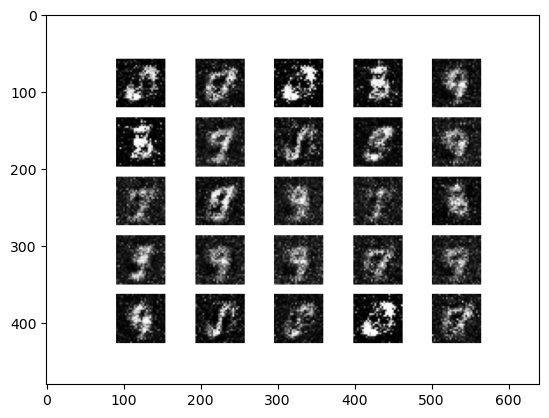

In [ ]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

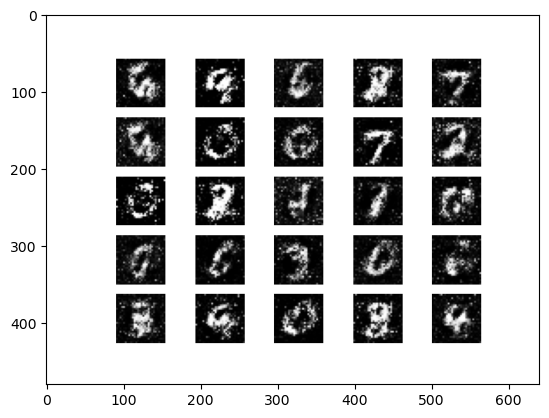

In [ ]:
a = imread('gan_images/1000.png')
plt.imshow(a)